#I. Các gói và thư viện cần thiết

##1. Cài đặt FinRL

In [ ]:
## install finrl library
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

!pip install stable-baselines[mpi]

!pip uninstall tensorflow --yes
!pip install tensorflow==1.15.4

!pip uninstall sklearn --yes
!pip install scikit-learn==0.21.1

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import warnings
warnings.filterwarnings("ignore")

##2. Các gói cần thiết

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

## 3. Tạo các thư mục cần thiết

In [ ]:
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [ ]:
config.RESULTS_DIR

'results'

# II. Môi trường

In [ ]:
#processed_full  =pd.read_csv('/content/gdrive/MyDrive/cs106_source/data/data_done_2009_2022.csv')

## 1. Chia dữ liệu

In [ ]:
import numpy as np
import pandas as pd
from stockstats import StockDataFrame as Sdf
#from config import config


def data_split(df,start,end):
    """
    split the dataset into training or testing using date
    :param data: (df) pandas dataframe, start, end
    :return: (df) pandas dataframe
    """
    data = df[(df.date >= start) & (df.date < end)]
    data=data.sort_values(['date','tic'],ignore_index=True)
    #data  = data[final_columns]
    data.index = data.date.factorize()[0]
    return data

##2. Môi trường giao dịch


In [ ]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle

# shares normalization factor
# 100 shares per trade
HMAX_NORMALIZE = 100
# initial amount of money we have in our account
INITIAL_ACCOUNT_BALANCE=1000000
# total number of stocks in our portfolio
STOCK_DIM = 30
# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001

# turbulence index: 90-150 reasonable threshold
#TURBULENCE_THRESHOLD = 140
REWARD_SCALING = 1e-4

class StockEnvTrade(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0,turbulence_threshold=140
                 ,initial=True, previous_state=[], model_name='', iteration=''):
        #super(StockEnv, self).__init__()
        #money = 10 , scope = 1
        self.day = day
        self.df = df
        self.initial = initial
        self.previous_state = previous_state
        # action_space normalization and shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 181: [Current Balance]+[prices 1-30]+[owned shares 1-30] 
        # +[macd 1-30]+ [rsi 1-30] + [cci 1-30] + [adx 1-30]
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (181,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        self.terminal = False     
        self.turbulence_threshold = turbulence_threshold
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      self.data.close.values.tolist() + \
                      [0]*STOCK_DIM + \
                      self.data.macd.values.tolist() + \
                      self.data.rsi.values.tolist() + \
                      self.data.cci.values.tolist() + \
                      self.data.adx.values.tolist()
        # initialize reward
        self.reward = 0
        self.turbulence = 0
        self.cost = 0
        self.trades = 0
        # memorize all the total balance change
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []
        #self.reset()
        self._seed()
        self.model_name=model_name        
        self.iteration=iteration


    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.turbulence<self.turbulence_threshold:
            if self.state[index+STOCK_DIM+1] > 0:
                #update balance
                self.state[0] += \
                self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
                 (1- TRANSACTION_FEE_PERCENT)
                
                self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
                self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
                 TRANSACTION_FEE_PERCENT
                self.trades+=1
            else:
                pass
        else:
            # if turbulence goes over threshold, just clear out all positions 
            if self.state[index+STOCK_DIM+1] > 0:
                #update balance
                self.state[0] += self.state[index+1]*self.state[index+STOCK_DIM+1]* \
                              (1- TRANSACTION_FEE_PERCENT)
                self.state[index+STOCK_DIM+1] =0
                self.cost += self.state[index+1]*self.state[index+STOCK_DIM+1]* \
                              TRANSACTION_FEE_PERCENT
                self.trades+=1
            else:
                pass
    
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        if self.turbulence< self.turbulence_threshold:
            available_amount = self.state[0] // self.state[index+1]
            # print('available_amount:{}'.format(available_amount))
            
            #update balance
            self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                              (1+ TRANSACTION_FEE_PERCENT)

            self.state[index+STOCK_DIM+1] += min(available_amount, action)
            
            self.cost+=self.state[index+1]*min(available_amount, action)* \
                              TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            # if turbulence goes over threshold, just stop buying
            pass
        
    def step(self, actions):
        # print(self.day)
        self.terminal = self.day >= len(self.df.index.unique())-1
        # print(actions)

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('results/account_value_trade_{}_{}.png'.format(self.model_name, self.iteration))
            plt.close()
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('results/account_value_trade_{}_{}.csv'.format(self.model_name, self.iteration))
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0]))           

            print("end_total_asset:{}".format(end_total_asset))
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))- self.asset_memory[0] ))
            print("total_cost: ", self.cost)
            print("total trades: ", self.trades)

            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            sharpe = (4**0.5)*df_total_value['daily_return'].mean()/ \
                  df_total_value['daily_return'].std()
            print("Sharpe: ",sharpe)
            
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('results/account_rewards_trade_{}_{}.csv'.format(self.model_name, self.iteration))
            
            # print('total asset: {}'.format(self.state[0]+ sum(np.array(self.state[1:29])*np.array(self.state[29:]))))
            #with open('obs.pkl', 'wb') as f:  
            #    pickle.dump(self.state, f)
            
            return self.state, self.reward, self.terminal,{}

        else:
            # print(np.array(self.state[1:29]))

            actions = actions * HMAX_NORMALIZE
            #actions = (actions.astype(int))
            if self.turbulence>=self.turbulence_threshold:
                actions=np.array([-HMAX_NORMALIZE]*STOCK_DIM)
                
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            #print("begin_total_asset:{}".format(begin_total_asset))
            
            argsort_actions = np.argsort(actions)
            
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])

            self.day += 1
            self.data = self.df.loc[self.day,:]         
            self.turbulence = self.data['turbulence'].values[0]
            #print(self.turbulence)
            #load next state
            # print("stock_shares:{}".format(self.state[29:]))
            self.state =  [self.state[0]] + \
                    self.data.close.values.tolist() + \
                    list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) + \
                    self.data.macd.values.tolist() + \
                    self.data.rsi.values.tolist() + \
                    self.data.cci.values.tolist() + \
                    self.data.adx.values.tolist()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.asset_memory.append(end_total_asset)
            #print("end_total_asset:{}".format(end_total_asset))
            
            self.reward = end_total_asset - begin_total_asset            
            # print("step_reward:{}".format(self.reward))
            self.rewards_memory.append(self.reward)
            
            self.reward = self.reward*REWARD_SCALING


        return self.state, self.reward, self.terminal, {}

    def reset(self):  
        if self.initial:
            self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
            self.day = 0
            self.data = self.df.loc[self.day,:]
            self.turbulence = 0
            self.cost = 0
            self.trades = 0
            self.terminal = False 
            #self.iteration=self.iteration
            self.rewards_memory = []
            #initiate state
            self.state = [INITIAL_ACCOUNT_BALANCE] + \
                          self.data.close.values.tolist() + \
                          [0]*STOCK_DIM + \
                          self.data.macd.values.tolist() + \
                          self.data.rsi.values.tolist()  + \
                          self.data.cci.values.tolist()  + \
                          self.data.adx.values.tolist() 
        else:
            previous_total_asset = self.previous_state[0]+ \
            sum(np.array(self.previous_state[1:(STOCK_DIM+1)])*np.array(self.previous_state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.asset_memory = [previous_total_asset]
            #self.asset_memory = [self.previous_state[0]]
            self.day = 0
            self.data = self.df.loc[self.day,:]
            self.turbulence = 0
            self.cost = 0
            self.trades = 0
            self.terminal = False 
            #self.iteration=iteration
            self.rewards_memory = []
            #initiate state
            #self.previous_state[(STOCK_DIM+1):(STOCK_DIM*2+1)]
            #[0]*STOCK_DIM + \

            self.state = [ self.previous_state[0]] + \
                          self.data.close.values.tolist() + \
                          self.previous_state[(STOCK_DIM+1):(STOCK_DIM*2+1)]+ \
                          self.data.macd.values.tolist() + \
                          self.data.rsi.values.tolist()  + \
                          self.data.cci.values.tolist()  + \
                          self.data.adx.values.tolist() 
            
        return self.state
    
    def render(self, mode='human',close=False):
        return self.state
    

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

#III. Chuẩn bị dữ liệu giao dịch


In [ ]:
!cp /content/gdrive/MyDrive/cs106_source/env/StockEnvTrain.py .

In [ ]:
# common library
import pandas as pd
import numpy as np
import time
import gym

# RL models from stable-baselines
from stable_baselines import PPO2
from stable_baselines import A2C
from stable_baselines import DDPG

from stable_baselines.ddpg.policies import DDPGPolicy
from stable_baselines.common.policies import MlpPolicy, MlpLstmPolicy, MlpLnLstmPolicy
from stable_baselines.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise, AdaptiveParamNoiseSpec
from stable_baselines.common.vec_env import DummyVecEnv
from sklearn.preprocessing import *

# customized env
from StockEnvTrain import StockEnvTrain
from StockEnvValidation import StockEnvValidation
from StockEnvTrade import StockEnvTrade

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
dow_30  =pd.read_csv('/content/gdrive/MyDrive/cs106_source/data/data_done_2009_2022.csv')

In [ ]:
insample_turbulence = dow_30[(dow_30.date<'2017-10-00') & (dow_30.date>='2009-01-01')]
insample_turbulence = insample_turbulence.drop_duplicates(subset=['date'])

In [ ]:
insample_turbulence.turbulence.describe()

count    2202.000000
mean       31.520826
std        33.299022
min         0.000000
25%        14.468111
50%        23.606064
75%        37.484884
max       343.089315
Name: turbulence, dtype: float64

In [ ]:
insample_turbulence_threshold = np.quantile(insample_turbulence.turbulence.values, 0.90)

In [ ]:
insample_turbulence_threshold

62.09458326054099

In [ ]:
# test data
test = data_split(dow_30, start='2018-01-01', end='2022-04-02')
# testing env
env_test = DummyVecEnv([lambda: StockEnvTrade(test, turbulence_threshold=insample_turbulence_threshold)])
obs_test = env_test.reset()

In [ ]:
def DRL_prediction(model, data, env, obs):
    print("==============Model Prediction===========")
    for i in range(len(data.index.unique())):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        env.render()

# IV. BackTesting

In [ ]:
!pip install git+https://github.com/quantopian/pyfolio

In [ ]:
import pandas as pd
import pyfolio
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

In [ ]:
def backtest_strat(df):
    strategy_ret= df.copy()
    strategy_ret['Date'] = pd.to_datetime(strategy_ret['Date'])
    strategy_ret.set_index('Date', drop = False, inplace = True)
    strategy_ret.index = strategy_ret.index.tz_localize('UTC')
    del strategy_ret['Date']
    ts = pd.Series(strategy_ret['daily_return'].values, index=strategy_ret.index)
    return ts

In [ ]:
def get_buy_and_hold_sharpe(test):
    test['daily_return']=test['Adj Close'].pct_change(1)

    sharpe = (252**0.5)*test['daily_return'].mean()/test['daily_return'].std()

    annual_return = ((test['daily_return'].mean()+1)**252-1)*100

    #annual_return = (test['daily_return'].mean())*252

    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)
    #return sharpe

#DJI

In [ ]:
dji = pd.read_csv("/content/gdrive/MyDrive/cs106_source/data/^DJI.csv")
test_dji = dji[(dji['Date']>= '2018-01-01') & (dji['Date']<='2022-04-01')]
test_dji = test_dji.reset_index(drop=True)
test_dji = test_dji.sort_values(['Date'], ignore_index=True)

In [ ]:
test_dji

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,24809.35,24864.19,24741.70,24824.01,24824.01,341130000.0
1,2018-01-03,24850.45,24941.92,24825.55,24922.68,24922.68,456790000.0
2,2018-01-04,24964.86,25105.96,24963.27,25075.13,25075.13,403280000.0
3,2018-01-05,25114.92,25299.79,25112.01,25295.87,25295.87,358020000.0
4,2018-01-08,25308.40,25311.99,25235.41,25283.00,25283.00,341390000.0
...,...,...,...,...,...,...,...
1066,2022-03-28,34833.03,34957.93,34552.23,34955.89,34955.89,299790000.0
1067,2022-03-29,35114.35,35372.26,35030.07,35294.19,35294.19,355050000.0
1068,2022-03-30,35273.63,35361.36,35058.58,35228.81,35228.81,317320000.0
1069,2022-03-31,35201.52,35201.52,34677.99,34678.35,34678.35,433400000.0


In [ ]:
## get manual results
get_buy_and_hold_sharpe(test_dji)

annual return:  10.958571031863794
sharpe ratio:  0.47314457152745537


In [ ]:
test_dji['daily_return']=test_dji['Adj Close'].pct_change(1)

In [ ]:
test_dji.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,daily_return
1066,2022-03-28,34833.03,34957.93,34552.23,34955.89,34955.89,299790000.0,0.002715
1067,2022-03-29,35114.35,35372.26,35030.07,35294.19,35294.19,355050000.0,0.009678
1068,2022-03-30,35273.63,35361.36,35058.58,35228.81,35228.81,317320000.0,-0.001852
1069,2022-03-31,35201.52,35201.52,34677.99,34678.35,34678.35,433400000.0,-0.015625
1070,2022-04-01,34740.89,34847.91,34538.25,34818.27,34818.27,340400000.0,0.004035


In [ ]:
dow_strat = backtest_strat(test_dji)

In [ ]:
dow_strat.to_csv('/content/dow_strat.csv')

##Cumulative Return

In [ ]:
dji_metrics = test_dji.copy()

In [ ]:
dji_metrics.head()

,Date,Open,High,Low,Close,Adj Close,Volume,daily_return
0,2018-01-02,24809.35,24864.19,24741.70,24824.01,24824.01,341130000.0,NaN
1,2018-01-03,24850.45,24941.92,24825.55,24922.68,24922.68,456790000.0,0.003975
2,2018-01-04,24964.86,25105.96,24963.27,25075.13,25075.13,403280000.0,0.006117
3,2018-01-05,25114.92,25299.79,25112.01,25295.87,25295.87,358020000.0,0.008803
4,2018-01-08,25308.40,25311.99,25235.41,25283.00,25283.00,341390000.0,-0.000509


In [ ]:
dji_metrics = dji_metrics[['Date', 'Adj Close']]
# make columns names prettier
dji_metrics.columns = ['date', 'price']

In [ ]:
df1 = dji_metrics.pivot_table(index=['date'], values=['price'])
# flatten columns multi-index, `date` will become the dataframe index
df1.columns = [col[1] for col in df1.columns.values]
df1

,r
date,
2018-01-02,24824.01
2018-01-03,24922.68
2018-01-04,25075.13
2018-01-05,25295.87
2018-01-08,25283.00
...,...
2022-03-28,34955.89
2022-03-29,35294.19
2022-03-30,35228.81


In [ ]:
cum_return = (df1.iloc[-1] - df1.iloc[0]) / df1.iloc[0]
cum_return

r    0.402605
dtype: float64

In [ ]:
cum_return*100

r    40.260458
dtype: float64

## Annual Volatility

In [ ]:
data = test_dji.copy()

In [ ]:
import numpy as np
data['Log returns'] = np.log(data['Close']/data['Close'].shift())

In [ ]:
data['Log returns'].std()

0.013926607591484447

In [ ]:
volatility = data['Log returns'].std()*252**.5

print(volatility*100)

22.107804176311234


Text(0.5, 1.0, 'volatility: 22.11%')

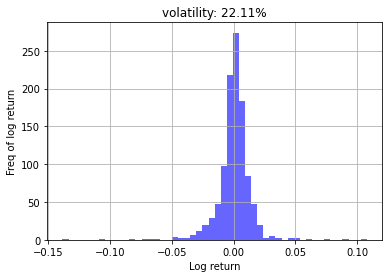

In [ ]:
str_vol = str(round(volatility, 4)*100)

fig, ax = plt.subplots()
data['Log returns'].hist(ax=ax, bins=50, alpha=0.6, color='b')
ax.set_xlabel('Log return')
ax.set_ylabel('Freq of log return')
ax.set_title('volatility: ' + str_vol + '%')

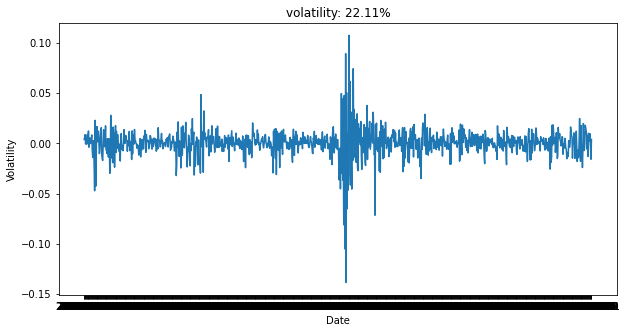

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(10, 5))

plt.plot(data['Date'], data['Log returns'])
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('volatility: ' + str_vol + '%')
plt.show()

##Maximum Drawdown

In [ ]:
daily_close = test_dji['Adj Close'].pct_change(1).dropna()

In [ ]:
wealth_index = 1000*(1+daily_close).cumprod()

previous_peaks=wealth_index.cummax()

drawdown = np.min((wealth_index-previous_peaks)/previous_peaks)

drawdown

-0.37086170478440605

#Model

In [ ]:
!mkdir /content/model
!cp -av  "/content/gdrive/MyDrive/cs106_source/model/trained_models_sharpe0.64_start20090101/DDPG_10k_dow_1134.zip" "/content/model"
!cp -av  "/content/gdrive/MyDrive/cs106_source/model/trained_models_sharpe0.64_start20090101/PPO_100k_dow_1134.zip" "/content/model"
!cp -av  "/content/gdrive/MyDrive/cs106_source/model/trained_models_sharpe0.64_start20090101/A2C_30k_dow_1134.zip" "/content/model"

'/content/gdrive/MyDrive/cs106_source/model/trained_models_sharpe0.64_start20090101/DDPG_10k_dow_1134.zip' -> '/content/model/DDPG_10k_dow_1134.zip'
'/content/gdrive/MyDrive/cs106_source/model/trained_models_sharpe0.64_start20090101/PPO_100k_dow_1134.zip' -> '/content/model/PPO_100k_dow_1134.zip'
'/content/gdrive/MyDrive/cs106_source/model/trained_models_sharpe0.64_start20090101/A2C_30k_dow_1134.zip' -> '/content/model/A2C_30k_dow_1134.zip'


In [ ]:
def get_daily_return(df):
    df['daily_return']=df.account_value.pct_change(1)
    #df=df.dropna()
    sharpe = (252**0.5)*df['daily_return'].mean()/ \
    df['daily_return'].std()
    
    annual_return = ((df['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)    
    return df

In [ ]:
rebalance_window = 63
validation_window = 63
unique_trade_date = dow_30[(dow_30.date > '2018-01-01')&(dow_30.date <= '2022-04-02')].date.unique()

print(unique_trade_date)
print(len(unique_trade_date))

['2018-01-02' '2018-01-03' '2018-01-04' ... '2022-03-30' '2022-03-31'
 '2022-04-01']
1071


##DDPG

In [ ]:
warnings.filterwarnings("ignore")
model_ddpg = DDPG.load("/content/model/DDPG_10k_dow_1134.zip")

In [ ]:
DRL_prediction(model=model_ddpg, 
               data=test,
               env=env_test, 
               obs=obs_test)

==============Model Prediction===========
previous_total_asset:1000000
end_total_asset:1461406.1063554497
total_reward:461406.10635544965
total_cost:  81462.50255288518
total trades:  21190
Sharpe:  0.09803338122418291


In [ ]:
## load results
df_account_value = pd.read_csv('/content/results/account_value_trade__.csv',index_col=0)

df_account_value = pd.DataFrame({'account_value':df_account_value['0'],
                                 'date':unique_trade_date})

#df_account_value = pd.DataFrame({'account_value':df_account_value['0']})

In [ ]:
## get manual results
df_account_value=get_daily_return(df_account_value)

annual return:  10.206550187569352
sharpe ratio:  0.7781158407059293


In [ ]:
# input for pyfolio
df_account_value['Date'] = test_dji['Date']
DRL_ddpg_strat = backtest_strat(df_account_value)

In [ ]:
DRL_ddpg_strat.to_csv('/content/DRL_ddpg_strat.csv')

In [ ]:
df_account_value

,account_value,date,daily_return,Date
0,1.000000e+06,2018-01-02,NaN,2018-01-02
1,1.000594e+06,2018-01-03,0.000594,2018-01-03
2,1.000345e+06,2018-01-04,-0.000249,2018-01-04
3,1.002508e+06,2018-01-05,0.002162,2018-01-05
4,1.001481e+06,2018-01-08,-0.001024,2018-01-08
...,...,...,...,...
1066,1.468859e+06,2022-03-28,0.000871,2022-03-28
1067,1.482613e+06,2022-03-29,0.009364,2022-03-29
1068,1.481720e+06,2022-03-30,-0.000602,2022-03-30
1069,1.457059e+06,2022-03-31,-0.016643,2022-03-31


Start date,2018-01-02
End date,2022-04-01
Total months,51
,Backtest
Annual return,9.338%
Cumulative returns,46.141%
Annual volatility,12.492%
Sharpe ratio,0.78
Calmar ratio,0.72
Stability,0.82
Max drawdown,-12.943%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.94,2020-06-08,2020-10-30,2021-01-07,154
1,10.18,2018-10-03,2019-01-03,2020-01-02,327
2,9.63,2018-02-26,2018-03-23,2018-09-19,148
3,6.04,2021-08-11,2021-09-30,2021-12-27,99
4,5.57,2020-02-12,2020-04-21,2020-05-08,63


Stress Events,mean,min,max
New Normal,0.04%,-7.23%,3.15%


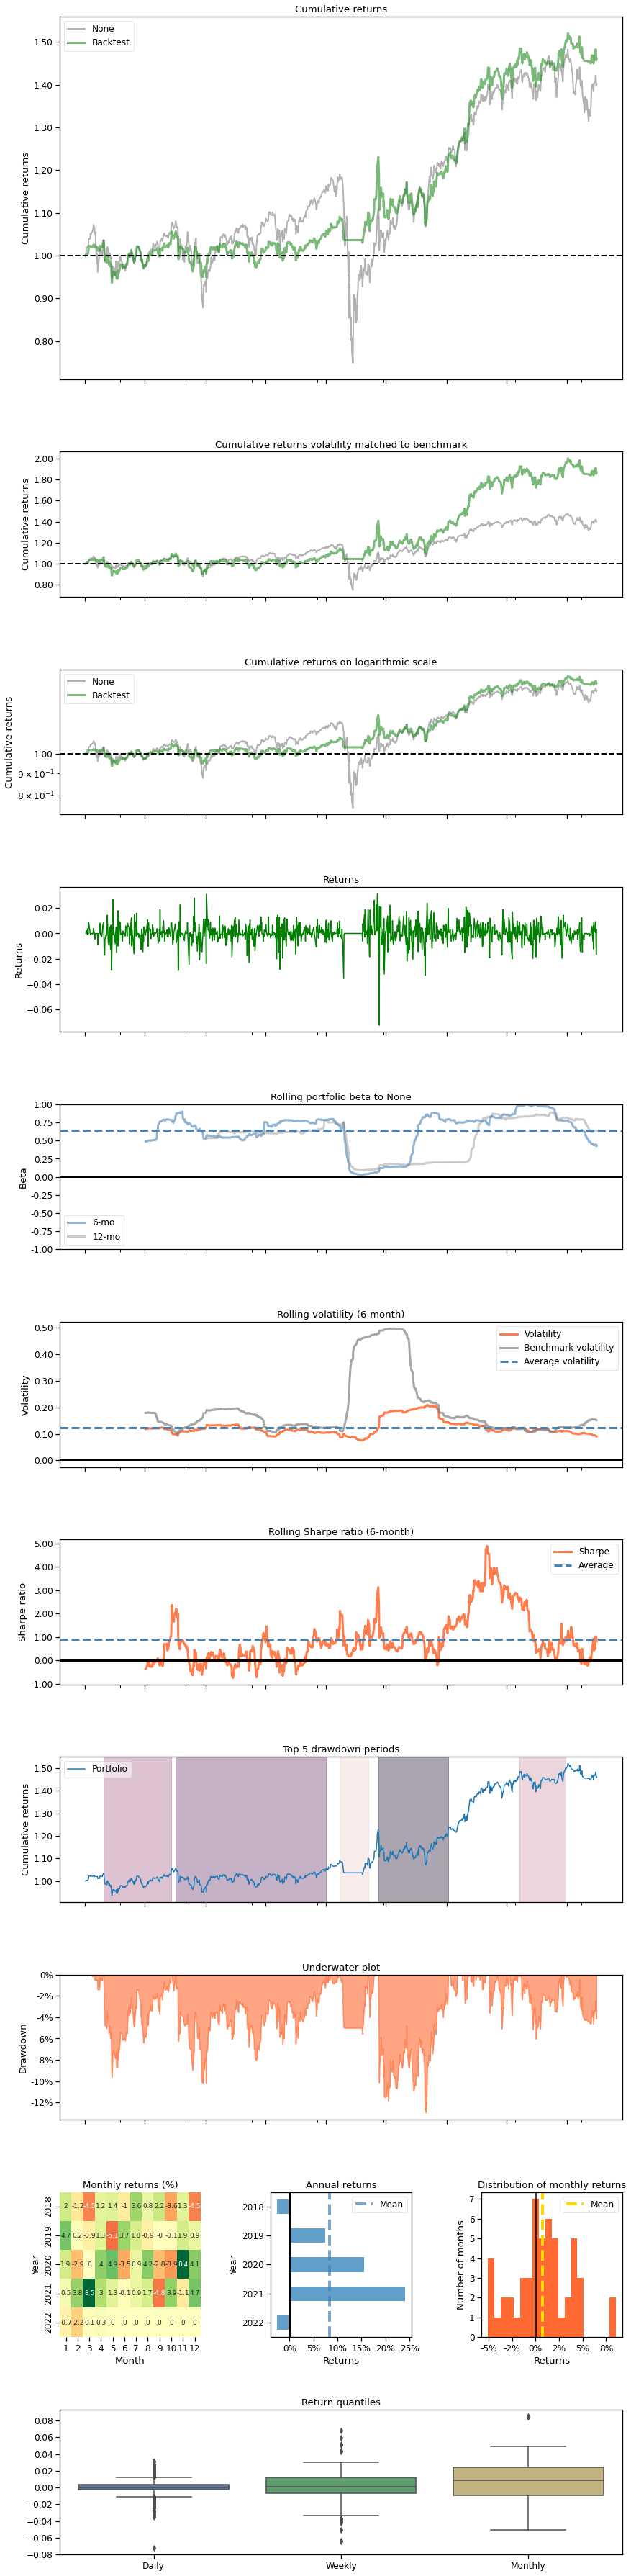

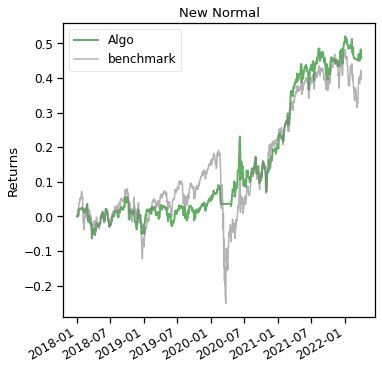

In [ ]:
%matplotlib inline
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = DRL_ddpg_strat,
                                   benchmark_rets=dow_strat, set_context=False)

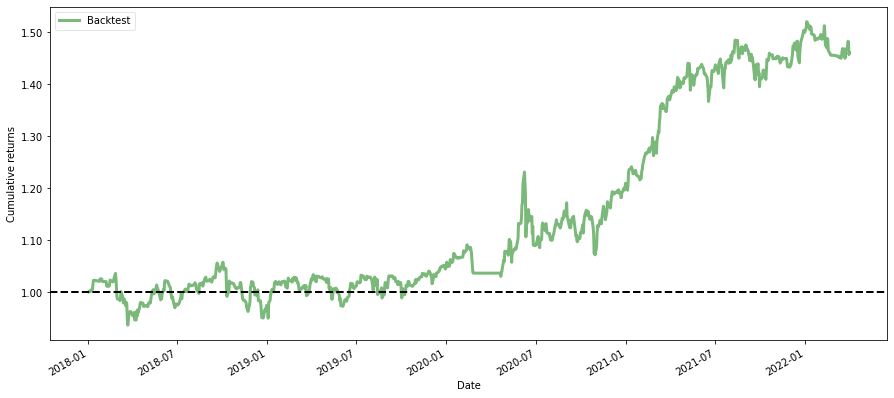

In [ ]:
# Cumulative Returns
fig = plt.figure(figsize=(15, 15))
plt.subplot(2,1,1)
pyfolio.plotting.plot_rolling_returns(DRL_ddpg_strat)

##A2C

In [ ]:
warnings.filterwarnings("ignore")
model_a2c = A2C.load("/content/model/A2C_30k_dow_1134.zip")




Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
DRL_prediction(model=model_a2c, 
               data=test,
               env=env_test, 
               obs=obs_test)

==============Model Prediction===========
previous_total_asset:1000000
end_total_asset:1183059.1416031597
total_reward:183059.14160315972
total_cost:  122423.07432991853
total trades:  21256
Sharpe:  0.06025594019437489


In [ ]:
## load results
df_account_value = pd.read_csv('/content/results/account_value_trade__.csv',index_col=0)

df_account_value = pd.DataFrame({'account_value':df_account_value['0'],
                                 'date':unique_trade_date})

#df_account_value = pd.DataFrame({'account_value':df_account_value['0']})

In [ ]:
## get manual results
df_account_value=get_daily_return(df_account_value)

annual return:  4.476610199967346
sharpe ratio:  0.478266698306092


In [ ]:
# input for pyfolio
df_account_value['Date'] = test_dji['Date']
DRL_a2c_strat = backtest_strat(df_account_value)

In [ ]:
DRL_a2c_strat.to_csv('/content/DRL_a2c_strat.csv')

Start date,2018-01-02
End date,2022-04-01
Total months,51
,Backtest
Annual return,4.035%
Cumulative returns,18.306%
Annual volatility,9.157%
Sharpe ratio,0.48
Calmar ratio,0.48
Stability,0.76
Max drawdown,-8.409%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.41,2020-09-02,2020-10-30,2021-04-15,162
1,7.09,2018-09-21,2019-01-03,2019-04-12,146
2,6.92,2018-02-26,2018-03-23,2018-08-27,131
3,6.49,2020-01-17,2020-07-09,2020-09-02,164
4,4.43,2021-08-16,2021-09-21,2021-10-19,47


Stress Events,mean,min,max
New Normal,0.02%,-4.48%,2.82%


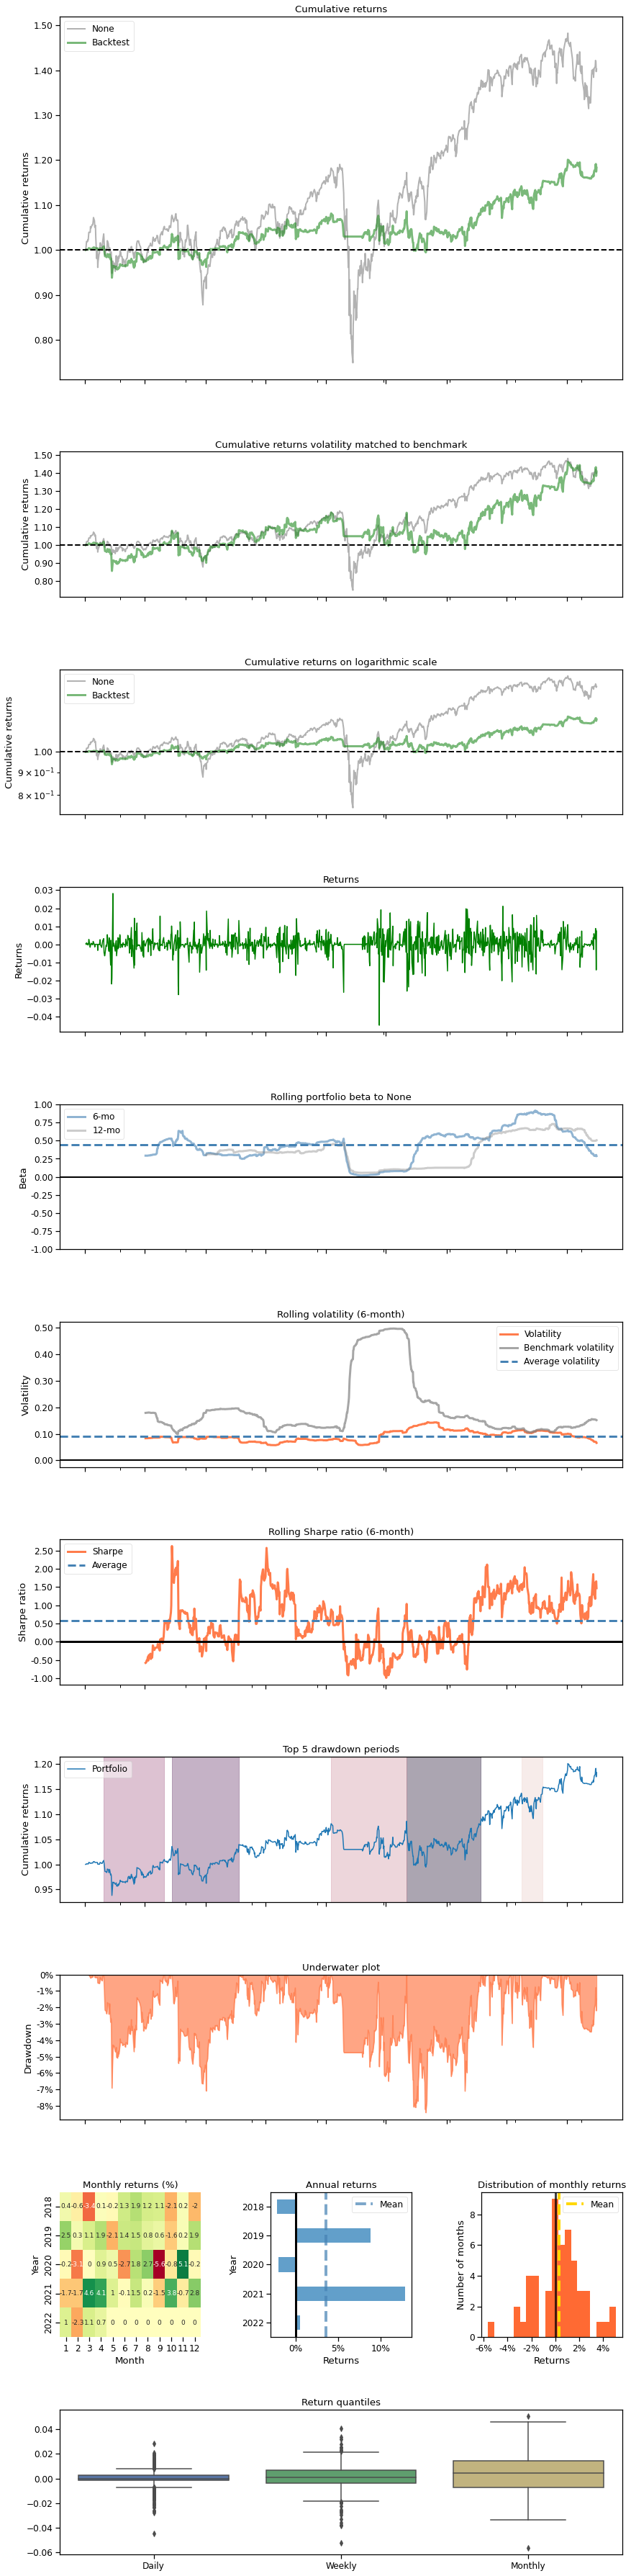

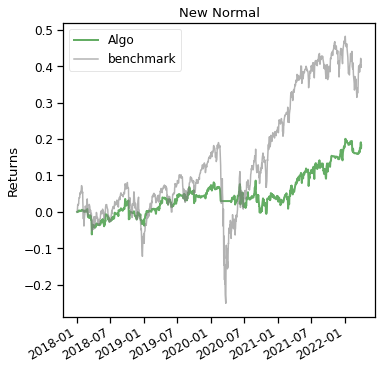

In [ ]:
%matplotlib inline
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = DRL_a2c_strat,
                                   benchmark_rets=dow_strat, set_context=False)

##PPO

In [ ]:
warnings.filterwarnings("ignore")
model_ppo = PPO2.load("/content/model/PPO_100k_dow_1134.zip")

In [ ]:
DRL_prediction(model=model_ppo, 
               data=test,
               env=env_test, 
               obs=obs_test)

==============Model Prediction===========
previous_total_asset:1000000
end_total_asset:1211223.790038355
total_reward:211223.79003835493
total_cost:  138175.2493184569
total trades:  23915
Sharpe:  0.07255714399291643


In [ ]:
## load results
df_account_value = pd.read_csv('/content/results/account_value_trade__.csv',index_col=0)

df_account_value = pd.DataFrame({'account_value':df_account_value['0'],
                                 'date':unique_trade_date})

#df_account_value = pd.DataFrame({'account_value':df_account_value['0']})

In [ ]:
## get manual results
df_account_value=get_daily_return(df_account_value)

annual return:  4.992087183183691
sharpe ratio:  0.5759044765390756


In [ ]:
# input for pyfolio
df_account_value['Date'] = test_dji['Date']
DRL_ppo_strat = backtest_strat(df_account_value)

In [ ]:
df_account_value

,account_value,date,daily_return,Date
0,1.000000e+06,2018-01-02,NaN,2018-01-02
1,1.000167e+06,2018-01-03,0.000167,2018-01-03
2,1.000079e+06,2018-01-04,-0.000089,2018-01-04
3,1.001108e+06,2018-01-05,0.001029,2018-01-05
4,1.000558e+06,2018-01-08,-0.000549,2018-01-08
...,...,...,...,...
1066,1.214485e+06,2022-03-28,0.000202,2022-03-28
1067,1.223179e+06,2022-03-29,0.007159,2022-03-29
1068,1.222886e+06,2022-03-30,-0.000240,2022-03-30
1069,1.205140e+06,2022-03-31,-0.014512,2022-03-31


In [ ]:
DRL_ppo_strat

Date
2018-01-02 00:00:00+00:00         NaN
2018-01-03 00:00:00+00:00    0.000167
2018-01-04 00:00:00+00:00   -0.000089
2018-01-05 00:00:00+00:00    0.001029
2018-01-08 00:00:00+00:00   -0.000549
                               ...   
2022-03-28 00:00:00+00:00    0.000202
2022-03-29 00:00:00+00:00    0.007159
2022-03-30 00:00:00+00:00   -0.000240
2022-03-31 00:00:00+00:00   -0.014512
2022-04-01 00:00:00+00:00    0.005049
Length: 1071, dtype: float64

Start date,2018-01-02
End date,2022-04-01
Total months,51
,Backtest
Annual return,4.612%
Cumulative returns,21.122%
Annual volatility,8.46%
Sharpe ratio,0.58
Calmar ratio,0.53
Stability,0.87
Max drawdown,-8.641%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.64,2020-06-08,2020-07-09,2021-02-22,186
1,6.75,2018-02-26,2018-03-23,2018-09-21,150
2,4.42,2018-10-09,2018-10-11,2019-04-12,134
3,4.18,2022-01-07,2022-03-15,NaT,NaN
4,3.89,2019-07-03,2019-10-02,2019-12-23,124


Stress Events,mean,min,max
New Normal,0.02%,-3.15%,1.96%


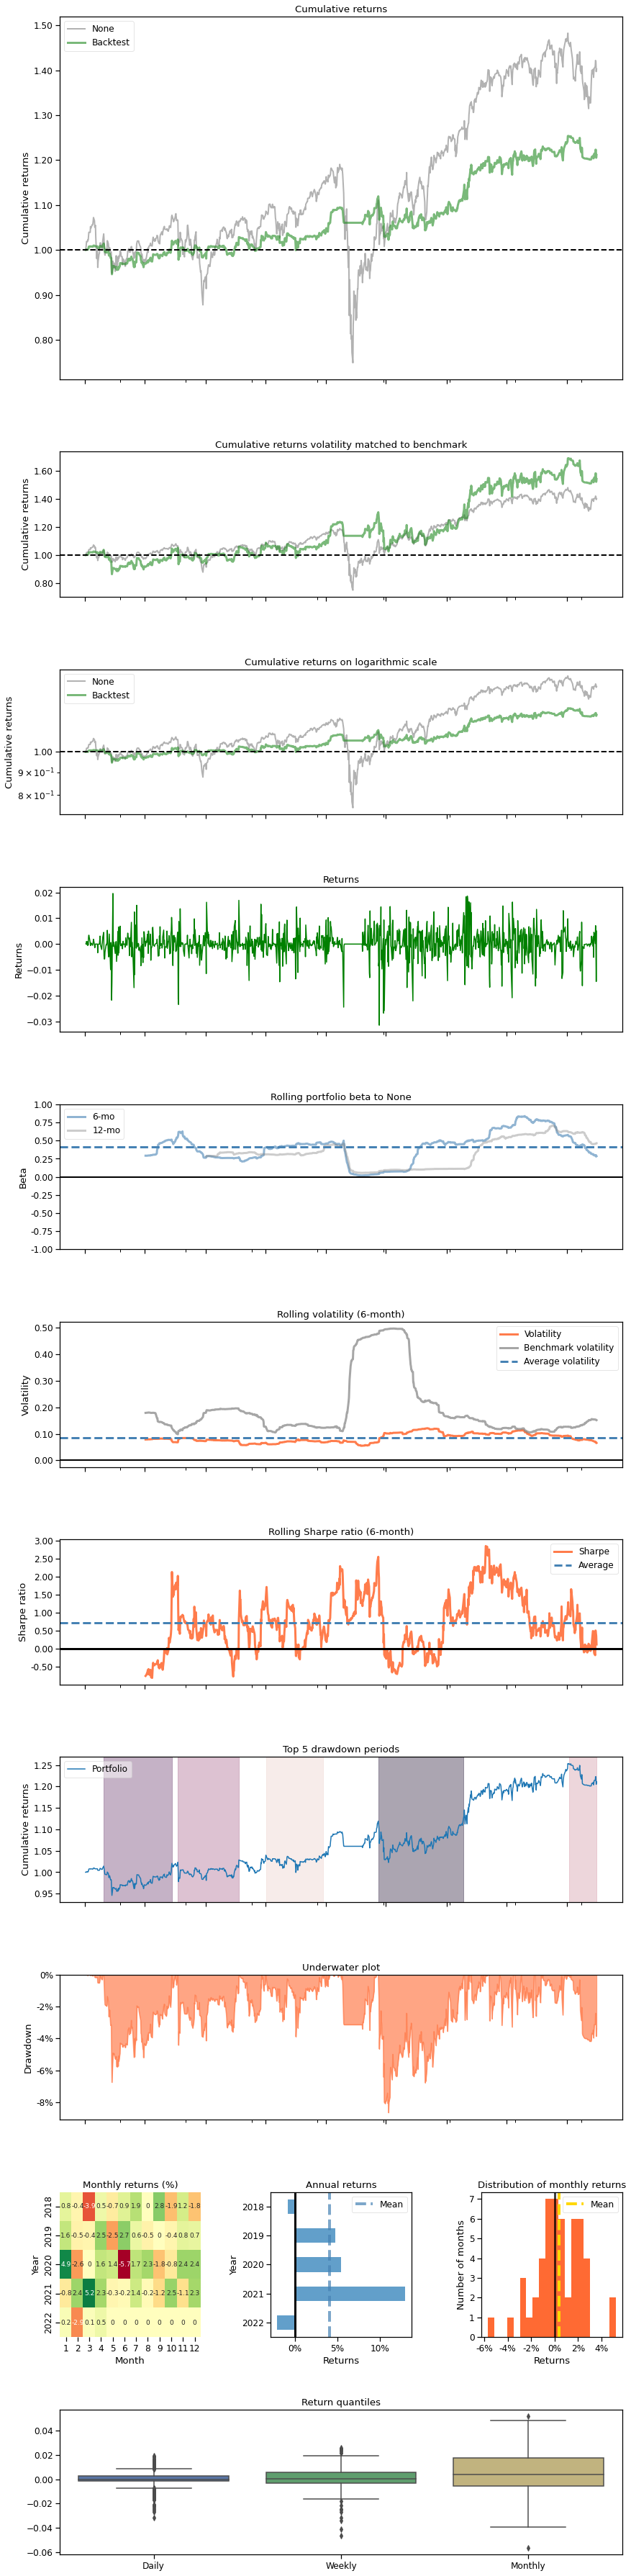

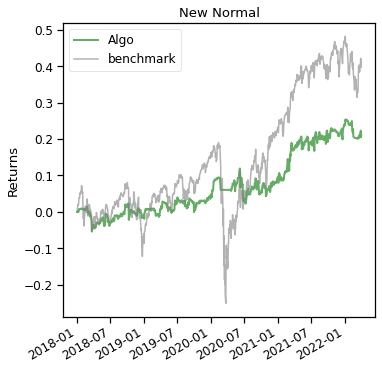

In [ ]:
%matplotlib inline
with pyfolio.plotting.plotting_context(font_scale=1.1):
    pyfolio.create_full_tear_sheet(returns = DRL_ppo_strat,
                                   benchmark_rets=dow_strat, set_context=False)

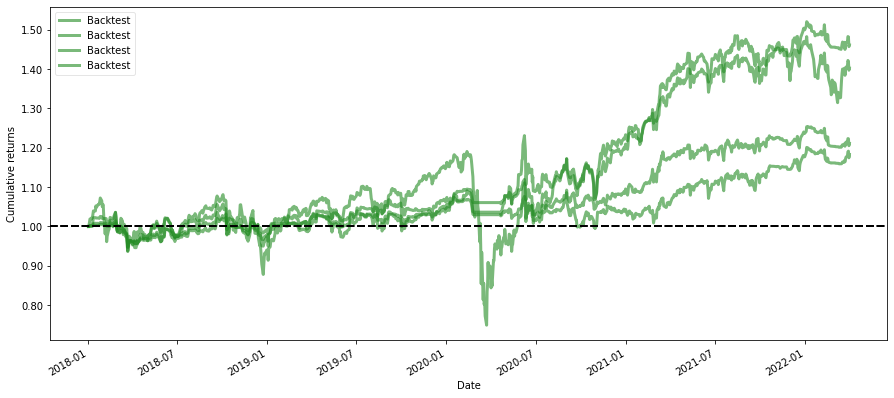

In [ ]:
# Cumulative Returns
fig = plt.figure(figsize=(15, 15))
plt.subplot(2,1,1)
pyfolio.plotting.plot_rolling_returns(DRL_ddpg_strat)
pyfolio.plotting.plot_rolling_returns(DRL_ppo_strat)
pyfolio.plotting.plot_rolling_returns(DRL_a2c_strat)
pyfolio.plotting.plot_rolling_returns(dow_strat)